<a href="https://colab.research.google.com/github/silverfuryK/Turbulence-Generation/blob/main/Variational_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AY0e-g6neEDeVVSJXkyBFKRlQsLthqC0WrFlUzonWHhjWqF1V3t-n9NKWZ0
Mounted at /gdrive


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
#from params3tensor import *
import random


In [ ]:
data = np.load('/gdrive/MyDrive/Fluid_Sets/Turb_iso_1024/600_points/np_arrays/data_chfirst.npy')
data_np = np.load('/gdrive/MyDrive/Fluid_Sets/Turb_iso_1024/600_points/np_arrays/data_new_nonan.npy')
params_data = np.load('/gdrive/MyDrive/Fluid_Sets/Turb_iso_1024/600_points/np_arrays/params_data_norm.npy')

In [ ]:
data = torch.tensor(data)
params_data = torch.tensor(params_data[1:])
if torch.cuda.is_available():
    data = data.to(device = 'cuda', dtype=torch.float)
    print('cuda available')
    params_data = params_data.to(device = 'cuda', dtype=torch.float)
    

train_dataset = (data, params_data)
# train_loader = torch.utils.data.DataLoader(data,shuffle=True,   batch_size = 1)

train_loader = torch.utils.data.DataLoader(train_dataset,shuffle=True,   batch_size = 1)


cuda available


In [ ]:
# model architecture

latent_size = 16
class encoder(nn.Module):
    def __init__(self):
        super(encoder, self).__init__()
        
        #encoder
        # inp >> 64
        # 64 >> 32
        self.conv1_1 = nn.Conv2d(16, 32, 3, padding = 1)
        self.conv1_2 = nn.Conv2d(32, 32, 3, padding = 1)
        self.conv1_3 = nn.Conv2d(32, 32, 3, padding = 1)
        self.pool1 = nn.MaxPool2d(2, 2)
        # 32 >> 16
        self.conv2_1 = nn.Conv2d(32, 64, 3, padding = 1)
        self.conv2_2 = nn.Conv2d(64, 64, 3, padding = 1)
        self.conv2_3 = nn.Conv2d(64, 64, 3, padding = 1)
        self.pool2 = nn.MaxPool2d(2, 2)
        # 16 >> 8
        self.conv3_1 = nn.Conv2d(64, 128, 3, padding = 1)
        self.conv3_2 = nn.Conv2d(128, 128, 3, padding = 1)
        self.conv3_3 = nn.Conv2d(128, 128, 3, padding = 1)
        self.pool3 = nn.MaxPool2d(2, 2)
        # 8 >> 4
        self.conv4_1 = nn.Conv2d(128, 128, 3, padding = 1)
        self.conv4_2 = nn.Conv2d(128, 128, 3, padding = 1)
        self.conv4_3 = nn.Conv2d(128, 128, 3, padding = 1)
        self.pool4 = nn.MaxPool2d(2, 2)
        
        self.down = nn.Upsample(size=(4, 4), mode = 'bilinear')
     
        # conv out 8x8
        #self.fc1 = nn.Linear(128 * 8 * 8, 64)
        
        self.fc1 = nn.Linear(256*4*4, 1024)
        #self.drop1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 128)
        #self.fc4 = nn.Linear(256, 256)
        #self.fc5 = nn.Linear(256, 256)
        
        # self.fc1_p = nn.Linear(8192, 1024)
        # self.fc2_p = nn.Linear(1024, 512)
        # self.fc3_p = nn.Linear(512, 256)
        self.fc4_p = nn.Linear(128, 128)
        self.fc5_p = nn.Linear(128, 64)
        
        self.fc_params = nn.Linear(64, 9)
        self.fc_latent_mu = nn.Linear(128, latent_size)
        self.fc_logvar = nn.Linear(128, latent_size+9)
        # self.bnorm_lat = nn.BatchNorm1d(256)
                      
    def forward(self, x):
        #encoder
        # -> n, 64, 64, 16
        xc1 = F.tanh(self.conv1_1(x))  # -> n, 32, 32, 32
        xc1 = F.tanh(self.conv1_2(xc1))  # -> n, 32, 32, 32
        xc1 = self.pool1(F.tanh(self.conv1_3(xc1)))  # -> n, 32, 32, 32
        #print("After conv1, shape is ", x.shape)
        xc2 = F.tanh(self.conv2_1(xc1))  # -> n, 64, 16, 16
        xc2 = F.tanh(self.conv2_2(xc2))  # -> n, 64, 16, 16
        xc2 = self.pool2(F.tanh(self.conv2_3(xc2)))  # -> n, 64, 16, 16
        #print("After conv3, shape is ", x.shape)
        xc3 = F.tanh(self.conv3_1(xc2))  # -> n, 128, 8, 8
        xc3 = F.tanh(self.conv3_2(xc3))  # -> n, 128, 8, 8
        xc3 = self.pool3(F.tanh(self.conv3_3(xc3)))  # -> n, 128, 8, 8
        #print("After conv3, shape is ", x.shape)
        xc4 = F.tanh(self.conv4_1(xc3))  # -> n, 128, 4, 4
        xc4 = F.tanh(self.conv4_2(xc4))  # -> n, 128, 4, 4
        xc4 = self.pool3(F.tanh(self.conv4_3(xc4)))  # -> n, 128, 4, 4
        
        xc3 = self.down(xc3)
        
        x = torch.cat((xc4,xc3),1)          # -> n, 128+128, 4, 4
     
        #x = x.view( 256 * 6 * 6)            # -> n, 8192
        # x = x.view(-1,8192)
        x = x.view(-1,256*4*4)
        #print(x.shape)
        
        x = F.tanh(self.fc1(x))               # -> n, 64
        x = F.tanh(self.fc2(x))               # -> n, 64
        x = F.tanh(self.fc3(x))               # -> n, 64
        
        # x_p = F.tanh(self.fc1_p(x))               # -> n, 64
        # x_p = F.tanh(self.fc2_p(x_p))               # -> n, 64
        # x_p = F.tanh(self.fc3_p(x_p))               # -> n, 64
        x_p = F.tanh(self.fc4_p(x))
        x_p = F.tanh(self.fc5_p(x_p))
        
        
        #x = F.tanh(self.fc4(x))
        #x = F.tanh(self.fc5(x))
        
        x_params = self.fc_params(x_p)
        x_latent_mu = self.fc_latent_mu(x)                    # -> n, 9 
        x_logvar = self.fc_logvar(x)                    # -> n, 3
        
        # con = torch.cat((lat1, lat2), -1)       # -> n, 12
        return x_params, x_latent_mu, x_logvar
       
class decoder(nn.Module):
    def __init__(self):
        super(decoder, self).__init__()
     #decoder
        # self.fc8 = nn.Linear(latent_size+9, 128)
        
        self.fc9 = nn.Linear(latent_size, 128)
        self.fc10 = nn.Linear(128, 256)
        self.fc11 = nn.Linear(256, 512)
        
        
        self.fc9_p = nn.Linear(9, 128)
        self.fc10_p = nn.Linear(128, 256)
        self.fc11_p = nn.Linear(256, 512)
        
        self.fc12 = nn.Linear(1024, 2048)
        #self.fc13 = nn.Linear(2048, 4096)
        self.fc14 = nn.Linear(2048, 8192)
        
        # self.conv4 = nn.ConvTranspose2d(128, 64, 3, stride = 2, padding = 1, output_padding = 1)
        # self.conv5 = nn.ConvTranspose2d(64, 32, 3, stride = 2, padding = 1, output_padding = 1)
        # self.conv6 = nn.ConvTranspose2d(32, 4, 3, stride = 2, padding = 1, output_padding = 1)
        
        #self.conv1T = nn.ConvTranspose2d(128, 128, 2, stride = 2, output_padding = 0, padding = 2) # out = 8
        #self.pool4 = nn.MaxUnpool2d(2, 2)
        self.up2 = nn.Upsample(size=(17, 17), mode = 'bilinear')
        self.conv2 = nn.Conv2d(128, 256, 2, padding = 0) #out = 16
        #self.bnorm1 = nn.BatchNorm2d(256)
        #self.conv_d1 = nn.Conv2d(256, 256, 1)
        self.bnorm2 = nn.BatchNorm2d(256)
        self.conv_d2 = nn.Conv2d(256, 256, 1)
        self.bnorm3 = nn.BatchNorm2d(256)
        #self.pool5 = nn.MaxUnpool2d(2, 2)
        self.up3 = nn.Upsample(size=(33, 33), mode = 'bilinear')
        self.conv3 = nn.Conv2d(256, 128, 2, padding = 0) # out = 32
        self.bnorm4 = nn.BatchNorm2d(128)
        self.conv_d3 = nn.Conv2d(128, 128, 1)
        self.bnorm5 = nn.BatchNorm2d(128)
        self.conv_d4 = nn.Conv2d(128, 128, 1)
        self.bnorm6 = nn.BatchNorm2d(128)
        #self.pool6 = nn.MaxUnpool2d(2, 2)
        self.up4 = nn.Upsample(size=(65, 65), mode = 'bilinear')
        self.conv4 = nn.Conv2d(128, 4, 2, padding = 0) # out = 64
        
        #self.pool7 = nn.MaxUnpool2d(2, 2)
        
        # self.conv_d1 = nn.Conv2d(128, 128, 3)       # out 64
        
        # self.conv_d2 = nn.Conv2d(128, 128, 3)       # out 64
        
        # self.conv_d3 = nn.Conv2d(128, 4, 5, padding = 4)   # out 64
        
    def forward(self, x_dec_in):
                 #decoder
        #x = torch.cat((x_params, x_reparam), -1)
        x_params = x_dec_in[:,0:9]
        x_reparam = x_dec_in[:,9:]

        x_par = F.tanh(self.fc9_p(x_params))
        x_par = F.tanh(self.fc10_p(x_par))
        x_par = F.tanh(self.fc11_p(x_par))
        
        # x = F.tanh(self.fc8(x))               # -> n, 8192
        x = F.tanh(self.fc9(x_reparam))
        x = F.tanh(self.fc10(x)) 
        x = F.tanh(self.fc11(x))
        
        x = torch.cat((x_par,x),-1)
        
        x = F.tanh(self.fc12(x))
        #x = F.tanh(self.fc13(x))
        x = F.tanh(self.fc14(x))
        
        x = x.view(-1, 128, 8,8)
        #print(x.shape)
        # x = torch.tanh(self.conv4(x))        # -> n, 64, 17, 17   
        #print("After conv4, shape is ", x.shape)
        # x = torch.tanh(self.conv5(x))         # -> n, 32, 33, 33
        # #print("After conv5, shape is ", x.shape)
        # x = torch.tanh(self.conv6(x))      # -> n, 16, 64, 64
        # #print("After conv6, shape is ", x.shape)
        
        #x = torch.tanh(self.conv1T(x))        # -> n, 64, 14, 14   
        #x = self.up1(x)
        #print("After up1, shape is ", x.shape)
       # x = self.pool5(x, indices2)
        x = self.up2(x)
        #print("After up2, shape is ", x.shape)
        x = torch.tanh(self.conv2(x))         # -> n, 32, 30, 30
        # x = self.bnorm1(x)
        #x = torch.tanh(self.conv_d1(x))
        x = self.bnorm2(x)
        x = torch.tanh(self.conv_d2(x))
        #print("After conv2T, shape is ", x.shape)
       # x = self.pool6(x, indices1)
        x = self.bnorm3(x)
        x = self.up3(x)
        x = torch.tanh(self.conv3(x))      # -> n, 16, 64, 64
        x = self.bnorm4(x)
        x = torch.tanh(self.conv_d3(x))
        x = self.bnorm5(x)
        x = torch.tanh(self.conv_d4(x))
        #x = self.up3(x)
        #print("After up3, shape is ", x.shape)
        x = self.bnorm6(x)
        x = self.up4(x)
        x = torch.tanh(self.conv4(x))      # -> n, 16, 64, 64
        
        #x = self.up3(x)
        #print("After up3, shape is ", x.shape)
        
        # x = torch.tanh(self.conv_d1(x))
        
        # x = torch.tanh(self.conv_d2(x))
        
        # x = torch.tanh(self.conv_d3(x))
        return x

class autoencoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(autoencoder, self).__init__()
        self.enc = encoder
        self.dec = decoder
        
    def forward(self, x):
        latent_params, latent_mu, latent_logvar = self.enc(x)
        n_latent_mu = torch.cat((latent_params,latent_mu), -1)
        latent = self.latent_sample(latent_params, latent_mu, latent_logvar)
        #print(latent.shape)
        x_recon = self.dec(latent)
        # x1 = self.enc(x)
        # x2 = self.dec(x1)
        return x_recon, n_latent_mu, latent_logvar
    
    def latent_sample(self,params, mu, log_var):
        if self.training:
            # the reparameterization trick
            mu_n = torch.cat((params,mu), -1)
            std = log_var.mul(0.5).exp_()
            # eps = std.data.new(std.size()).normal_()
            # std_f = std[0]
            eps = torch.normal(0.0, std)
            reparam = eps.mul(std).add_(mu_n)
            return reparam
        else:
          mu_n = torch.cat((params,mu), -1)
          return mu_n


enc = encoder().to(device= 'cuda')
dec = decoder().to(device= 'cuda')
model = autoencoder(enc, dec).to(device= 'cuda')
    

print(model)
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)
num_paramsE = sum(q.numel() for q in enc.parameters() if q.requires_grad)
print('Number of parameters in Encoder: %d' % num_paramsE)
num_paramsD = sum(r.numel() for r in dec.parameters() if r.requires_grad)
print('Number of parameters in Decoder: %d' % num_paramsD)


autoencoder(
  (enc): encoder(
    (conv1_1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv1_2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv1_3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2_3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3_3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, 

In [ ]:
# define custom losses
criterion = nn.MSELoss()

def vae_loss(recon_x, x, mu, logvar):
    
    variational_beta = 1
    recon_loss = F.mse_loss(recon_x.view(-1, 4*64*64), x.view(-1, 4*64*64), reduction='sum')
    kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())    
    return (1*recon_loss) + variational_beta * kldivergence

In [ ]:
# optimizers and schedulers
optimizer1 = torch.optim.Adam(model.parameters(), lr = 0.000002,weight_decay=1e-5)
optimizer2 = torch.optim.Adam(enc.parameters(), lr = 0.00005,weight_decay=1e-5)

scheduler1 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer1, 'min', factor=0.5, patience = 50, threshold = 0.00001, eps=1e-9, verbose = True)
scheduler2 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer2, 'min', patience = 10, threshold = 0.0000001, verbose = True)

#loss1_arr = []
#loss2_arr = []

# if training is alread done
#loss1_arr = torch.tensor(loss1_arr).to(device = 'cuda')
#loss2_arr = torch.tensor(loss2_arr).to(device = 'cuda')
#loss1_arr = loss1_arr.tolist()
#loss2_arr = loss2_arr.tolist()

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# training loops

num_epochs = 800
#n_total_steps = len(train_loader)
i = 0
#loss1_arr = torch.tensor([]).to('cuda', dtype=torch.float)
#loss2_arr = torch.tensor([]).to('cuda', dtype=torch.float)

bat = 5
dat_len = 600


model.train()

for epoch in range(num_epochs):
    i = 0
    ind = 0
    # batch loop
    mul = 0
    Tloss1 = torch.tensor(0).to('cuda', dtype=torch.float)
    Tloss2 = torch.tensor(0).to('cuda', dtype=torch.float)
    for dat in range(0,int((dat_len/bat))):
        # bat_loss1 = torch.tensor(0).to('cuda', dtype=torch.float)
        # bat_loss2 = torch.tensor(0).to('cuda', dtype=torch.float)
        
        i = 0
        # for imgs in data[dat*bat:(dat+1)*bat]:
        imgs = data[dat*bat:(dat+1)*bat]    
        imgs = imgs.to(device = 'cuda')
        # imgs = torch.unsqueeze(imgs,0)
        # imgs = torch.unsqueeze(imgs,1)
        #params = params.to(device)

        # Forward pass
        latent_params,_,_ = enc(imgs)
        # outputs = model(imgs)
        # loss1 = criterion(outputs, data[dat*bat:(dat+1)*bat,0:4,:,:])
        
        image_batch_recon, latent_mu, latent_logvar = model(imgs)
        
        # reconstruction error
        loss1 = vae_loss(image_batch_recon, data[dat*bat:(dat+1)*bat,0:4,:,:] , latent_mu, latent_logvar)
        
        # parameter error
        loss2 = criterion(latent_params[:,0:9], params_data[dat*bat:(dat+1)*bat])
        
        #loss2 = criterion(model.fc4.weight[:,63], params_data[i])
        #loss = loss1**2 + loss2**2
        # bat_loss1 = bat_loss1 + loss1
        # bat_loss2 = bat_loss2 + loss2
        Tloss1 = Tloss1 + abs(loss1)
        Tloss2 = Tloss2 + abs(loss2)
        # Backward and optimize
        optimizer1.zero_grad() # AE
        optimizer2.zero_grad() # ENC
        loss1.backward() # AE
        loss2.backward() # ENC
        optimizer1.step()
        optimizer2.step()
        # ind = ind + 1
        
        # if (dat*bat+i) % 100 == 0:
        #     print (f'Epoch [{epoch+1}/{num_epochs}], batch [{dat}/{dat_len/bat}], Loss_image: {loss1.item():.4f}, Loss_params: {loss2.item():.4f}')
        #     i = i + 1
        
        mul = mul + 1
    Tloss1 = Tloss1/120
    Tloss2 = Tloss2/120
    loss1_arr.append(Tloss1)
    loss2_arr.append(Tloss2)
    #scheduler1.step(Tloss1)
    #scheduler2.step(Tloss2)
    print (f'Epoch [{epoch}], TLoss_image: {Tloss1.item():.6f}, TLoss_param: {Tloss2.item():.6f}')

loss1_arr = torch.stack(loss1_arr)
loss2_arr = torch.stack(loss2_arr)



/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Epoch [0], TLoss_image: 1647.200317, TLoss_param: 0.397767
Epoch [1], TLoss_image: 1644.907349, TLoss_param: 0.393855
Epoch [2], TLoss_image: 1642.412598, TLoss_param: 0.390811
Epoch [3], TLoss_image: 1642.367920, TLoss_param: 0.388383
Epoch [4], TLoss_image: 1642.215454, TLoss_param: 0.387563
Epoch [5], TLoss_image: 1643.218750, TLoss_param: 0.398603
Epoch [6], TLoss_image: 1643.567017, TLoss_param: 0.391159
Epoch [7], TLoss_image: 1642.705322, TLoss_param: 0.391367
Epoch [8], TLoss_image: 1642.341309, TLoss_param: 0.388689
Epoch [9], TLoss_image: 1639.802002, TLoss_param: 0.391805
Epoch [10], TLoss_image: 1639.475464, TLoss_param: 0.390334
Epoch [11], TLoss_image: 1640.942749, TLoss_param: 0.390686
Epoch [12], TLoss_image: 1640.635254, TLoss_param: 0.386458
Epoch [13], TLoss_image: 1641.163818, TLoss_param: 0.387087
Epoch [14], TLoss_image: 1640.625244, TLoss_param: 0.390346
Epoch [15], TLoss_image: 1642.295410, TLoss_param: 0.385661
Epoch [16], TLoss_image: 1645.524048, TLoss_param:

KeyboardInterrupt: ignored

In [ ]:
loss1_arr.shape

AttributeError: ignored

<Figure size 432x288 with 0 Axes>

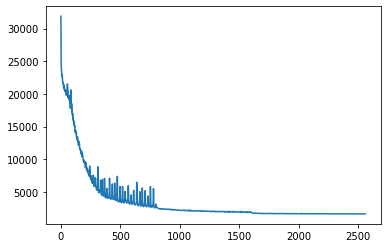

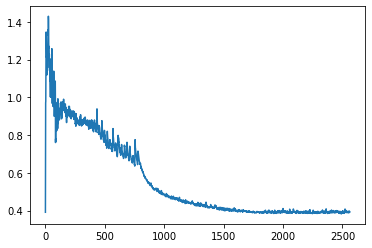

<Figure size 432x288 with 0 Axes>

In [ ]:
#loss1_arr = torch.stack(loss1_arr).detach().cpu()
#loss2_arr = torch.stack(loss2_arr).detach().cpu()
#loss1_arr = loss1_arr.to(device = 'cpu').detach().numpy()
#loss2_arr = loss2_arr.to(device = 'cpu').detach().numpy()
#loss1_arr1 = torch.stack(loss1_arr)
#loss2_arr1 = torch.stack(loss2_arr)
np.save('/gdrive/MyDrive/Fluid_Sets/Turb_iso_1024/600_points/models/state_dicts/cnn_ae_var_testv_8_sd_loss1.npy', loss1_arr)
np.save('/gdrive/MyDrive/Fluid_Sets/Turb_iso_1024/600_points/models/state_dicts/cnn_ae_var_testv_8_sd_loss2.npy', loss2_arr)

plt.plot(range(0,len(loss1_arr)), loss1_arr)
plt.figure()
plt.plot(range(0,len(loss2_arr)), loss2_arr)
plt.figure()

In [ ]:

# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer1's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer1.state_dict():
    print(var_name, "\t", optimizer1.state_dict()[var_name])

# Print optimizer2's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer2.state_dict():
    print(var_name, "\t", optimizer2.state_dict()[var_name])




In [ ]:
# saving state dicts
torch.save(model.state_dict(), '/gdrive/MyDrive/Fluid_Sets/Turb_iso_1024/600_points/models/state_dicts/cnn_ae_var_testv_8_sd')
torch.save(dec.state_dict(), '/gdrive/MyDrive/Fluid_Sets/Turb_iso_1024/600_points/models/state_dicts/cnn_ae_var_testv_8_sd_decoder')
torch.save(enc.state_dict(), '/gdrive/MyDrive/Fluid_Sets/Turb_iso_1024/600_points/models/state_dicts/cnn_ae_var_testv_8_sd_encoder')

In [ ]:
# save
torch.save(model, '/gdrive/MyDrive/Fluid_Sets/Turb_iso_1024/600_points/models/cnn_ae_var_testv_8')
torch.save(dec, '/gdrive/MyDrive/Fluid_Sets/Turb_iso_1024/600_points/models/cnn_ae_var_testv_8_decoder')
torch.save(enc, '/gdrive/MyDrive/Fluid_Sets/Turb_iso_1024/600_points/models/cnn_ae_var_testv_8_encoder')


In [ ]:
#import numpy as np
# save np.load
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

# call load_data with allow_pickle implicitly set to true
loss1_arr = np.load('/gdrive/MyDrive/Fluid_Sets/Turb_iso_1024/600_points/models/state_dicts/cnn_ae_var_testv_8_sd_loss1.npy')
loss2_arr = np.load('/gdrive/MyDrive/Fluid_Sets/Turb_iso_1024/600_points/models/state_dicts/cnn_ae_var_testv_8_sd_loss2.npy')

# restore np.load for future normal usage
np.load = np_load_old

In [ ]:
# load for eval
model.load_state_dict(torch.load( '/gdrive/MyDrive/Fluid_Sets/Turb_iso_1024/600_points/models/state_dicts/cnn_ae_var_testv_8_sd'))
dec.load_state_dict(torch.load( '/gdrive/MyDrive/Fluid_Sets/Turb_iso_1024/600_points/models/state_dicts/cnn_ae_var_testv_8_sd_decoder'))
enc.load_state_dict(torch.load( '/gdrive/MyDrive/Fluid_Sets/Turb_iso_1024/600_points/models/state_dicts/cnn_ae_var_testv_8_sd_encoder'))
#loss1_arr = np.load('/gdrive/MyDrive/Fluid_Sets/Turb_iso_1024/600_points/models/state_dicts/cnn_ae_var_testv_8_sd_loss1.npy')
#loss2_arr = np.load('/gdrive/MyDrive/Fluid_Sets/Turb_iso_1024/600_points/models/state_dicts/cnn_ae_var_testv_8_sd_loss2.npy')
model.eval()

autoencoder(
  (enc): encoder(
    (conv1_1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv1_2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv1_3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2_3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3_3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, 

405


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


<Figure size 432x288 with 0 Axes>

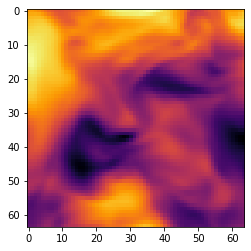

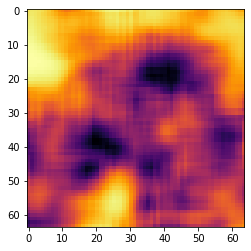

<Figure size 432x288 with 0 Axes>

In [ ]:
# simgle frame eval
model.eval()
sample = random.randint(0, 600)
print(sample)
test_img = data[sample]
test_img = torch.unsqueeze(test_img,0)
pred_data,_,_ = model(test_img)
test_img = test_img.to(device = 'cpu')
test_img = test_img.detach().numpy()
pred_data = pred_data.to(device = 'cpu')
pred_data = pred_data.detach().numpy()
plt.imshow(test_img[0,0,:,:], cmap='inferno')
plt.figure()
plt.imshow(pred_data[0,0,:,:], cmap='inferno')
plt.figure()

128


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


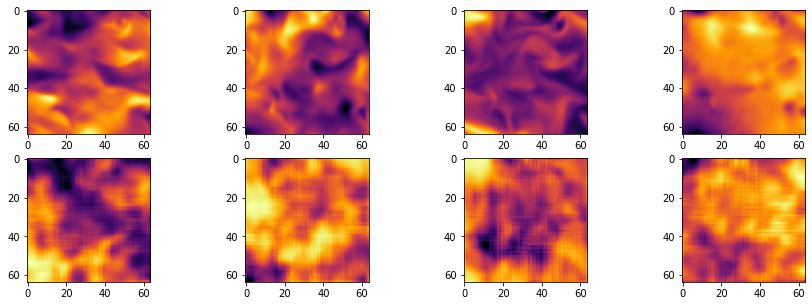

In [ ]:
#channel comparison

sample = random.randint(0, 600)
sample = 128
print(sample)
test_img = data[58]
test_img = torch.unsqueeze(test_img,0)
pred_data,_,_ = model(test_img)
test_img = test_img.to(device = 'cpu')
test_img = test_img.detach().numpy()
pred_data = pred_data.to(device = 'cpu')
pred_data = pred_data.detach().numpy()
#plot

fig,a = plt.subplots(2,4,figsize=(15,5))
a[0][0].imshow(test_img[0,0,:,:], cmap='inferno')
a[0][1].imshow(test_img[0,1,:,:], cmap='inferno')
a[0][2].imshow(test_img[0,2,:,:], cmap='inferno')
a[0][3].imshow(test_img[0,3,:,:], cmap='inferno')
a[1][0].imshow(pred_data[0,0,:,:], cmap='inferno')
a[1][1].imshow(pred_data[0,1,:,:], cmap='inferno')
a[1][2].imshow(pred_data[0,2,:,:], cmap='inferno')
a[1][3].imshow(pred_data[0,3,:,:], cmap='inferno')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


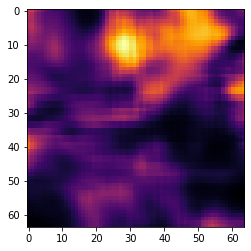

In [ ]:

ex_param = torch.rand(16).to('cuda', dtype=torch.float);
n_param = params_data[415]
vec = torch.cat((ex_param, n_param), -1)
vec = torch.unsqueeze(vec,0)
rand_img = dec(n_param, ex_param)
rand_img = rand_img.to(device = 'cpu')
rand_img = rand_img.detach().numpy()
plt.imshow(rand_img[0,0,:,:], cmap='inferno')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


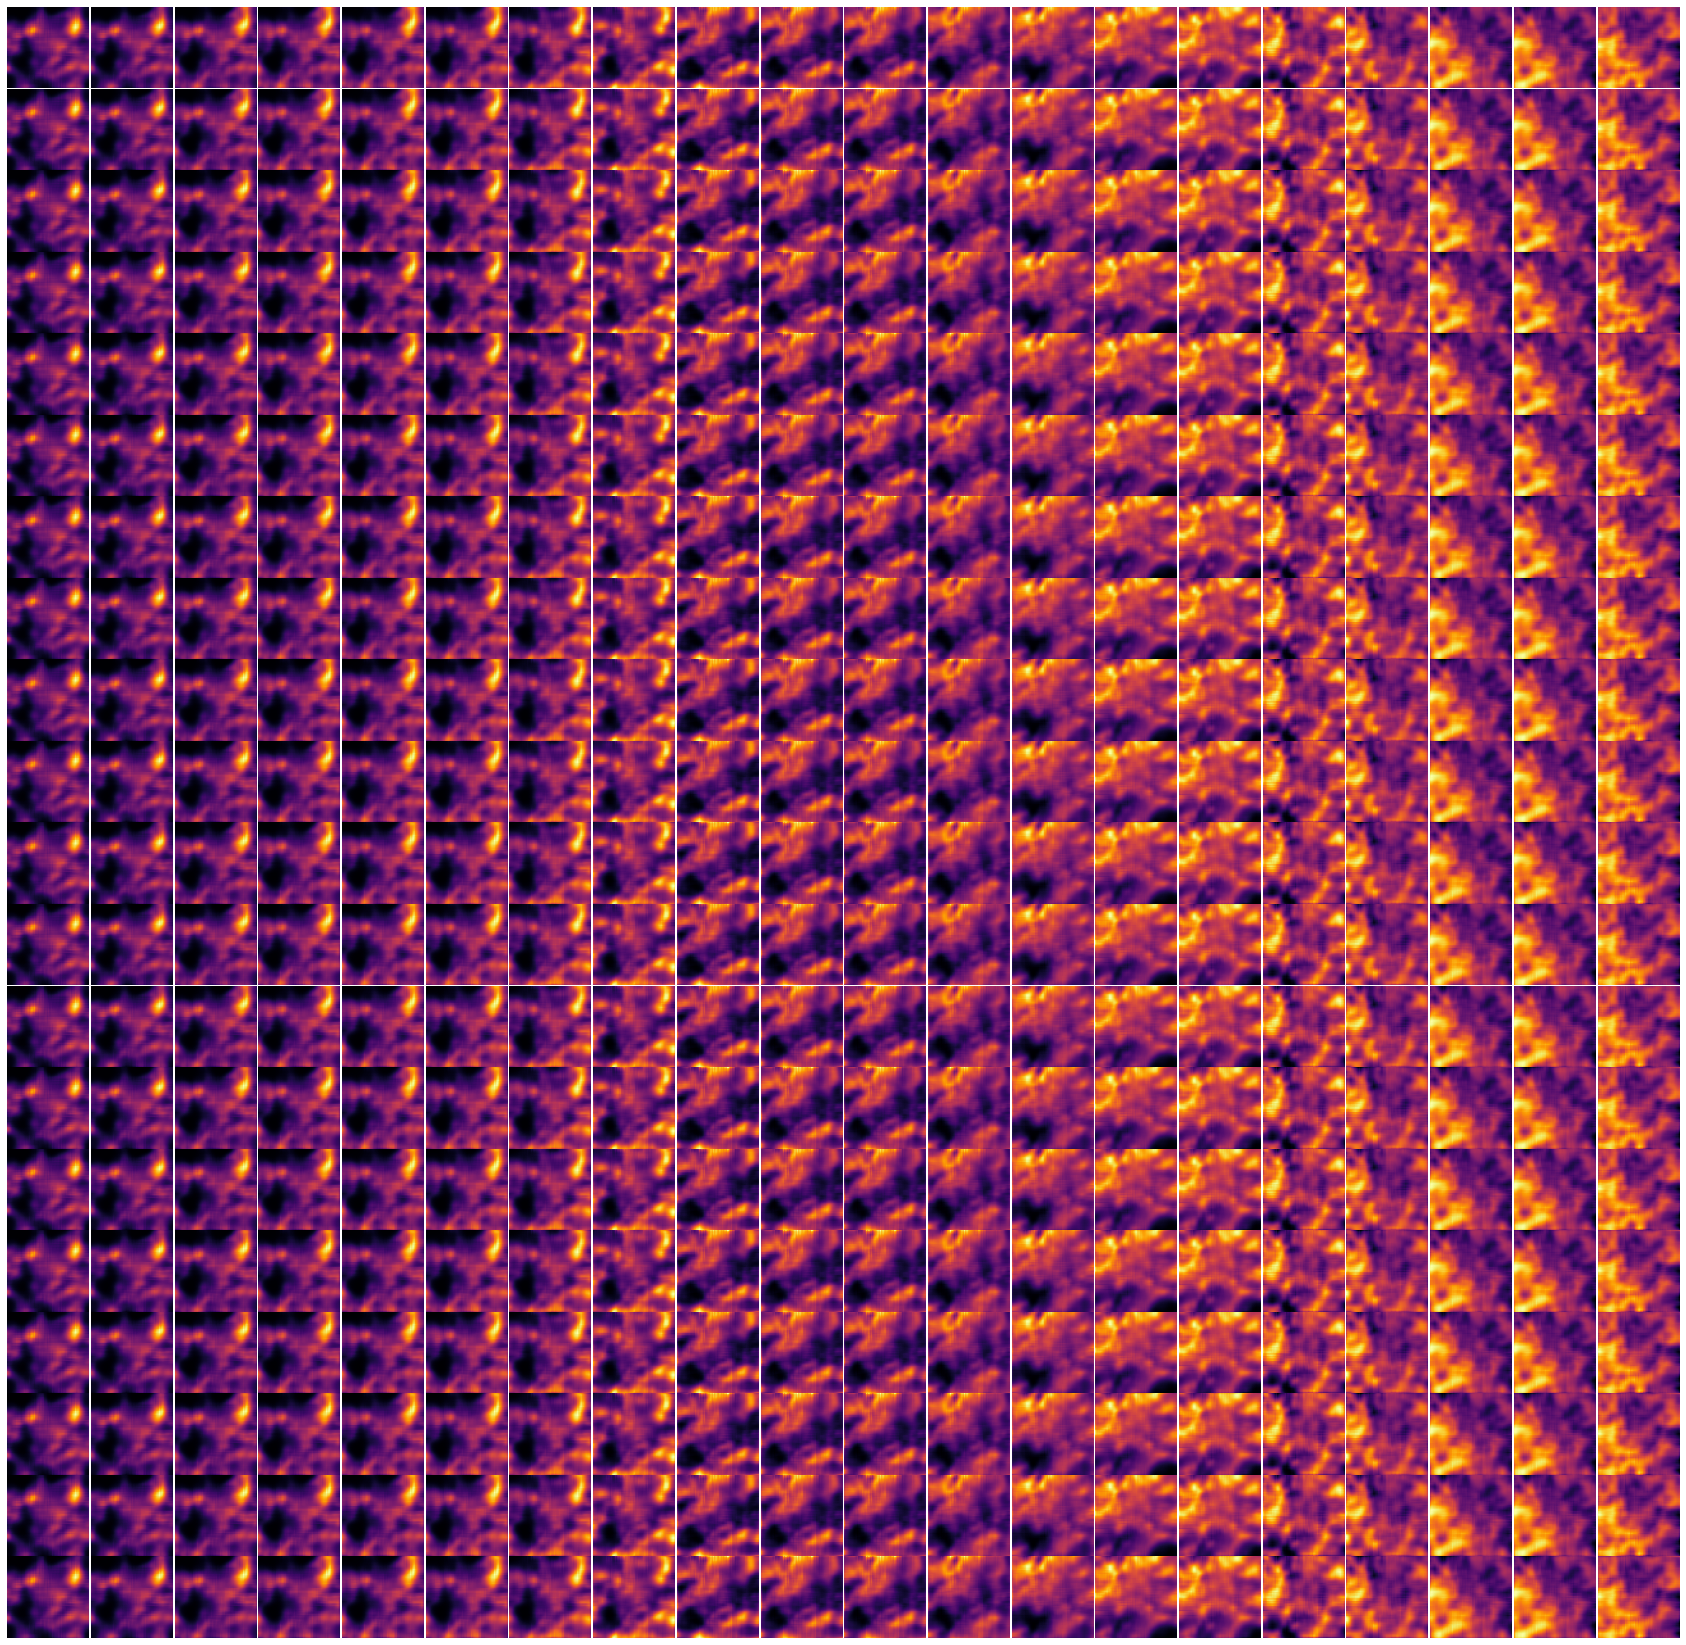

<Figure size 432x288 with 0 Axes>

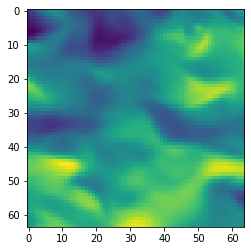

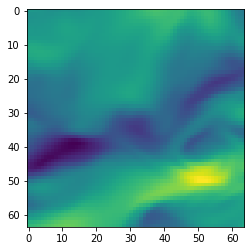

<Figure size 432x288 with 0 Axes>

In [ ]:
# interpolation in latent space

def interpolation(lambda1, lambda2, model, img1, img2):
    
    with torch.no_grad():
    
        # latent vector of first image
        img1 = img1.to(device = 'cuda')
        param1, latent_1, _, = enc(img1)

        # latent vector of second image
        img2 = img2.to(device = 'cuda')
        param2, latent_2, _ = enc(img2)

        # interpolation of the two latent vectors
        inter_latent = lambda1* latent_1 + (1- lambda1) * latent_2

        # interpolation of the two parameter vectors
        inter_param = lambda2* param1 + (1- lambda2) * param2

        # reconstruct interpolated image
        inter_image = dec(torch.cat((inter_param, inter_latent),-1))
        inter_image = inter_image.cpu()

        return inter_image
    
points = 20

# interpolation lambdas
lambda1_range=np.linspace(-0.75,0.75,points)
lambda2_range=np.linspace(-0.75,0.75,points)

fig, axs = plt.subplots(20,20, figsize=(30, 30))
fig.subplots_adjust(hspace = 0.001, wspace=.0005)

axs = axs.ravel()

ind1 = 58
ind2 = 480
inp_img1 = torch.unsqueeze(data[ind1],0)
inp_img2 = torch.unsqueeze(data[ind2],0)
c = 0
for ind_l2, l2 in enumerate(lambda2_range):
  for ind_l1, l1 in enumerate(lambda1_range):
      inter_image=interpolation(float(l1), float(l2), model, inp_img1, inp_img2)
    
      # inter_image = to_img(inter_image)
      
      image = inter_image.numpy()
      i = ind_l2 * points + ind_l1
      axs[i].imshow(image[0,0,:,:], cmap='inferno')
      axs[i].set_axis_off()
      # axs[ind].set_title('lambda1_val='+str(round(l1,1)+'; lambda2_val='+str(round(l2,1)))
      #c = c + 1
plt.show() 
# fig.savefig('/gdrive/MyDrive/Fluid_Sets/Turb_iso_1024/600_points/models/interpolation.png')
plt.figure()

inp_img1 = (data[ind1])
inp_img1 = inp_img1.to(device = 'cpu').detach().numpy()
inp_img2 = (data[ind2])
inp_img2 = inp_img2.to(device = 'cpu').detach().numpy()
plt.imshow(inp_img1[0,:,:])
plt.figure()
plt.imshow(inp_img2[0,:,:])
plt.figure()

<Figure size 432x288 with 0 Axes>

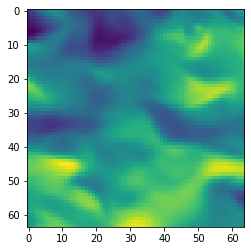

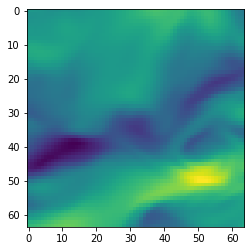

<Figure size 432x288 with 0 Axes>

In [ ]:

inp_img1 = (data[ind1])
inp_img1 = inp_img1.to(device = 'cpu').detach().numpy()
inp_img2 = (data[ind2])
inp_img2 = inp_img2.to(device = 'cpu').detach().numpy()
plt.imshow(inp_img1[0,:,:])
plt.figure()
plt.imshow(inp_img2[0,:,:])
plt.figure()

In [ ]:
# generated interpolation in latent space

def latent_variation(lambda1, lambda2, model, img_ind):
    
    with torch.no_grad():
    
        # latent vector of first image
        img1 = torch.unsqueeze(data[img_ind],0)
        #img1 = img1.to(device = 'cuda')
        latent_vec, _, = enc(img1)
        #latent_vec = param_data[img_ind]
        latent_1 = latent_vec[9]
        latent_2 = latent_vec[10]

        # interpolation of the two latent vectors
        inter_latent1 = lambda1* latent_1 + (1- lambda1) * latent_2

        # interpolation of the two parameter vectors
        inter_latent2 = lambda2* param1 + (1- lambda2) * param2
        inter_param = torch.cat((latent_vec[0:9],inter_latent1,inter_latent1), axis = -1)
        inter_param = torch.unsqeeze(inter_param,0)
        # reconstruct interpolated image
        inter_image = dec(inter_param)
        inter_image = inter_image.cpu()

        return inter_image
    
points = 20

# interpolation lambdas
lambda1_range=np.linspace(-0.5,0.5,points)
lambda2_range=np.linspace(-0.5,0.5,points)

fig, axs = plt.subplots(20,20, figsize=(30, 30))
fig.subplots_adjust(hspace = 0.001, wspace=.0005)

axs = axs.ravel()

ind1 = 58
inp_img1 = torch.unsqueeze(data[ind1],0)
c = 0

for ind_l2, l2 in enumerate(lambda2_range):
  for ind_l1, l1 in enumerate(lambda1_range):
      inter_image = latent_variation(float(l1), float(l2), model, inp_img1)
    
      # inter_image = to_img(inter_image)
      
      image = inter_image.numpy()
      i = ind_l2 * points + ind_l1
      axs[i].imshow(image[0,0,:,:], cmap='inferno')
      axs[i].set_axis_off()
      # axs[ind].set_title('lambda1_val='+str(round(l1,1)+'; lambda2_val='+str(round(l2,1)))
      #c = c + 1

plt.show() 
# fig.savefig('/gdrive/MyDrive/Fluid_Sets/Turb_iso_1024/600_points/models/interpolation.png')
plt.figure()

inp_img1 = (data[ind1])
inp_img1 = inp_img1.to(device = 'cpu').detach().numpy()
# inp_img2 = (data[ind2])
# inp_img2 = inp_img2.to(device = 'cpu').detach().numpy()
plt.imshow(inp_img1[0,:,:])
plt.figure()
# plt.imshow(inp_img2[0,:,:])
# plt.figure()

In [ ]:
import torch
from torch import nn
%pip install -U git+https://github.com/szagoruyko/pytorchviz.git@master
from torchviz import make_dot, make_dot_from_trace
from graphviz import Source

  Cloning https://github.com/szagoruyko/pytorchviz.git (to revision master) to /tmp/pip-req-build-ea8d308i
  Running command git clone -q https://github.com/szagoruyko/pytorchviz.git /tmp/pip-req-build-ea8d308i
  Created wheel for torchviz: filename=torchviz-0.0.2-cp37-none-any.whl size=4970 sha256=cdd95e581fb6ecea8f0a3df7b617ec76980d0c1384690ba82a495922677d64a3
  Stored in directory: /tmp/pip-ephem-wheel-cache-wfa34a8v/wheels/fc/d6/e6/66dc628cd51f1839234ed28feeba942a6f68bc69cec3b8f137
Successfully built torchviz
  Found existing installation: torchviz 0.0.2
    Uninstalling torchviz-0.0.2:
      Successfully uninstalled torchviz-0.0.2


In [ ]:
# plot model

sample = random.randint(0, 600)
print(sample)
test_img = data[sample]
test_img = torch.unsqueeze(test_img,0)

model_arch = make_dot(model(test_img), params=dict(model.named_parameters()), show_attrs=True, show_saved=True)
Source(model_arch).render('/gdrive/MyDrive/Fluid_Sets/Turb_iso_1024/600_points/models/cnn_ae_var_testv_7_arch')

316


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torchviz/dot.py:68: UserWarning: make_dot: showing grad_fn attributes and saved variables requires PyTorch version >= 1.9. (This does NOT apply to saved tensors saved by custom autograd functions.)
  "make_dot: showing grad_fn attributes and saved variables"


'/gdrive/MyDrive/Fluid_Sets/Turb_iso_1024/600_points/models/cnn_ae_var_testv_7_arch.pdf'

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


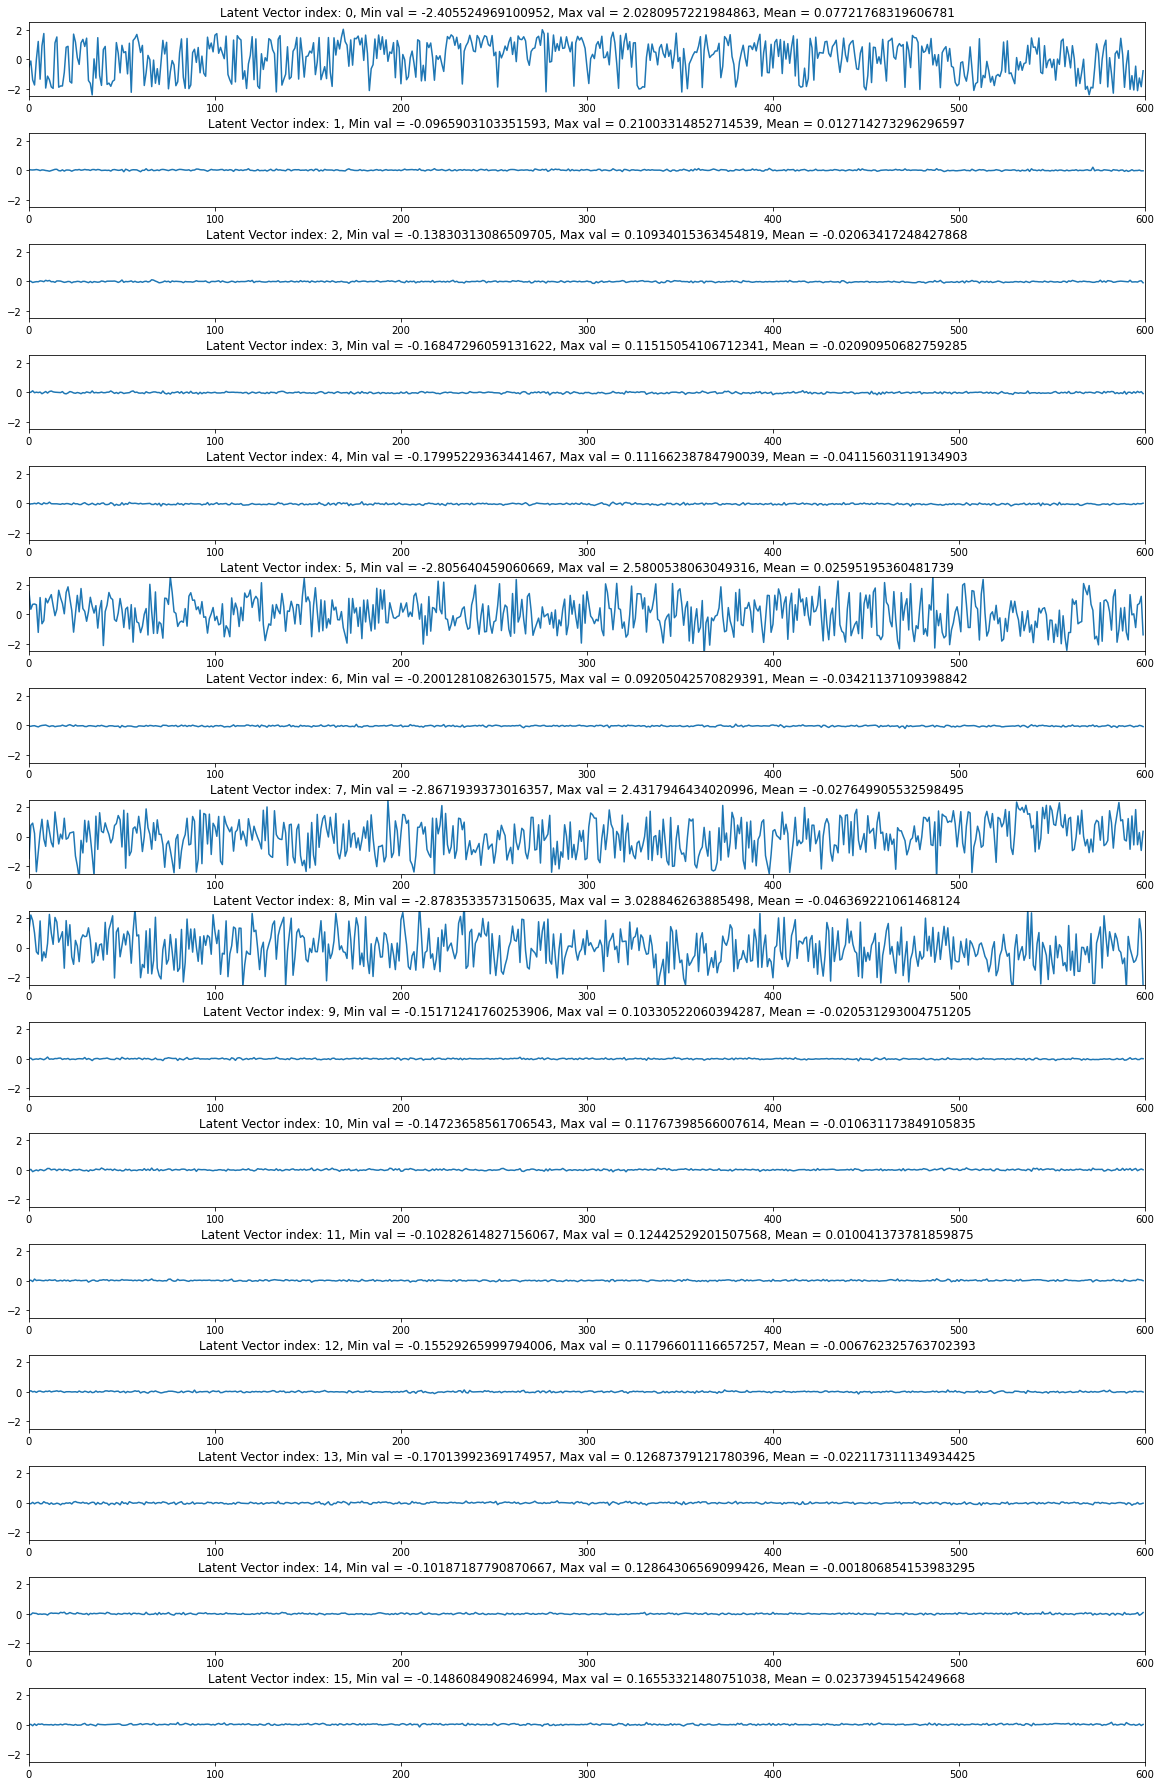

In [ ]:
# evaluating latent vectors
latent_vec_eval = torch.empty((len(data),latent_size))
param,latent_vec_eval,_ = enc(data)
latent_vec_eval = latent_vec_eval.to(device = 'cpu').detach().numpy()
param = param.to(device = 'cpu').detach().numpy()

fig, axs = plt.subplots(latent_size,1, figsize=(20, 2*16))
fig.subplots_adjust(hspace = 0.5, wspace=.0005)

min_lat, max_lat, mean_lat = np.empty((len(data))),np.empty((len(data))),np.empty((len(data)))

for i in range(0, latent_size):
  min_lat[i] = np.min(latent_vec_eval[:,i])
  max_lat[i] = np.max(latent_vec_eval[:,i])
  min_lat[i] = np.mean(latent_vec_eval[:,i])
  axs[i].plot(range(0,len(data)), latent_vec_eval[:,i])
  axs[i].axis([0, 600, -2.5, 2.5])
  axs[i].set_title("Latent Vector index: {}, Min val = {}, Max val = {}, Mean = {}".format(i,np.min(latent_vec_eval[:,i]), np.max(latent_vec_eval[:,i]), np.mean(latent_vec_eval[:,i])))

print()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Flow parameters = tensor([2.2520e-02, 1.7667e-01, 2.1013e-02, 4.5165e-04, 1.7443e+00, 1.6322e-04,
        2.9802e-05, 2.6424e-02, 3.6985e-02], device='cuda:0')


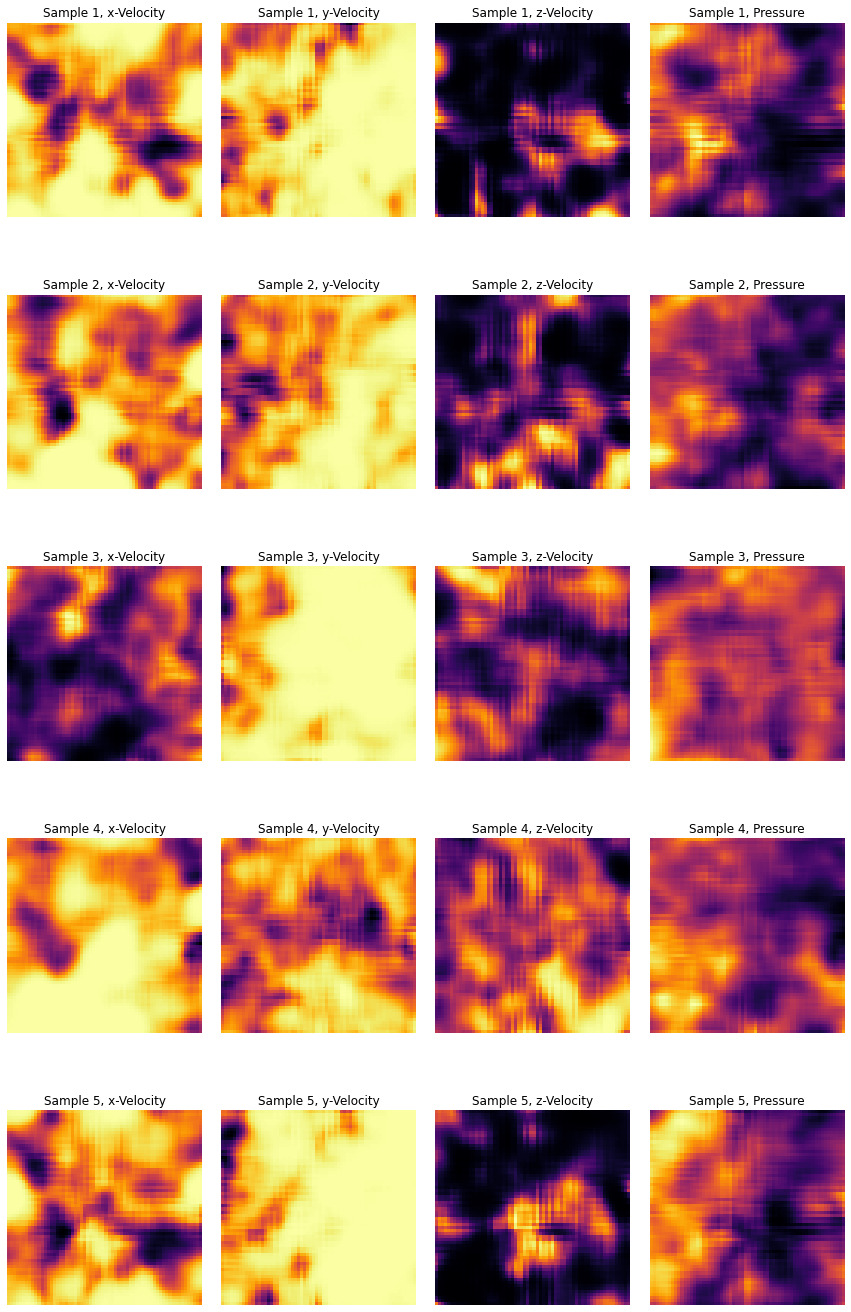

In [ ]:
# decoder variation
N_gen = 5
num_channel = 4
sample_param = params_data[random.randint(0,600)]

fig, axs = plt.subplots(N_gen, num_channel, figsize=(15, 5*N_gen))
fig.subplots_adjust(hspace = 0.001, wspace=.1)
#axs.title.set_text("Generated samples of Param vector =  {}".format(sample_param))
for n in range(0, N_gen):
  
  latent_sample = torch.empty(latent_size).to(device = 'cuda')
  for i in range(0, latent_size):
    latent_sample[i] = random.uniform(min_lat[i], max_lat[i])

  dec_inp = torch.cat((sample_param, latent_sample), 0)
  dec_inp = torch.unsqueeze(dec_inp, 0)
  im_out = dec(dec_inp)
  im_out = im_out.to(device = 'cpu').detach().numpy()
  im_ind = int(n*num_channel)

  #axs[im_ind+0].imshow(im_out[0,0,:,:], cmap='inferno')
  #axs[im_ind+1].imshow(im_out[0,1,:,:], cmap='inferno')
  #axs[im_ind+2].imshow(im_out[0,2,:,:], cmap='inferno')
  #axs[im_ind+3].imshow(im_out[0,3,:,:], cmap='inferno')

  axs[n,0].imshow(im_out[0,0,:,:], cmap='inferno')
  axs[n,0].set_title('Sample {}, x-Velocity'.format(n+1))
  axs[n,0].set_axis_off()
  axs[n,1].imshow(im_out[0,1,:,:], cmap='inferno')
  axs[n,1].set_title('Sample {}, y-Velocity'.format(n+1))
  axs[n,1].set_axis_off()
  axs[n,2].imshow(im_out[0,2,:,:], cmap='inferno')
  axs[n,2].set_title('Sample {}, z-Velocity'.format(n+1))
  axs[n,2].set_axis_off()
  axs[n,3].imshow(im_out[0,3,:,:], cmap='inferno')
  axs[n,3].set_title('Sample {}, Pressure'.format(n+1))
  axs[n,3].set_axis_off()

print('Flow parameters = {}'.format(dec_inp[0,0:9]))


